# Height GWAS Separate train and test

This is GWAS analysis for tz2014 data to find snps associate with height

## 1. Import

In [1]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from scipy import stats

import matplotlib.pyplot as plt

#from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from sklearn import linear_model
import random

## 2. Load Data

In [4]:
(tz_bim,tz_fam,tz_bed) = read_plink('ddat/crowdAI/all2964/bin_final_strand')

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.27s/it]


In [5]:
tz_maf =  pd.read_csv(PATH/'TZ14_one.frq',delim_whitespace=True)

In [6]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)

## 3. Clean Data

In [7]:
def select_snp(arr):
    if arr[0]==0 or arr[0]==26:
        return 0
    elif arr[4]<0.05 or arr[4]>0.95:
        return 0
    elif arr[2]=='A' and arr[3]=='T':
        return 0
    elif arr[2]=='T' and arr[3]=='A':
        return 0
    elif arr[2]=='G' and arr[3]=='C':
        return 0
    elif arr[2]=='C' and arr[3]=='G':
        return 0
    else:
        return 1

In [8]:
def plink_slice(p,pb=None,pf=None):
    """
    p: list of bim, fam, bed
    pb: index of bim
    pf: index of fam
    """
    (bim,fam,bed)=p
    if pb:
        bim = bim.iloc[pb]
        bed = bed[pb,:]
    if pf:
        fam = fam.iloc[pf]
        bed = bed[:,pf]
    return(bim,fam,bed)

In [9]:
tz_maf_filter = tz_maf.apply(select_snp, axis=1)
tz_maf_new=tz_maf.loc[tz_maf_filter==1,]

In [10]:
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),list(tz_maf_new.index),tz_sample_index)

## 4. GWAS Model

### 4.1 Linear GWAS

In [11]:
tz_meta=all_meta.loc[tz_sub[1].iid,]

In [22]:
val_idx = pd.read_csv('TTS_Model/gwas_val_idx.csv',index_col=0,header=None)
val_idx = list(val_idx.iloc[:,0])

In [26]:
tz_snps=tz_sub[2].compute()
tz_snps = pd.DataFrame(tz_snps)
tz_snps.fillna(-1,inplace=True)

In [27]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, tz_snps.T, tz_meta)

In [28]:
val.shape,trn.shape,y_val.shape,y_trn.shape

((550, 684066), (2197, 684066), (550, 8), (2197, 8))

In [29]:
sum(y_val.gender==1)

208

In [155]:
from snp2h import *

In [255]:
list(tmpr_rs_c.index[tmpr_rs_c>=10])

['rs710841',
 'rs1712374',
 'rs710839',
 'rs7624084',
 'rs16932725',
 'rs1901568',
 'kgp5403113',
 'rs6535239',
 'rs724016']

In [382]:
tmpr_rs_c_pos=[boo2idx(tz_sub[0].snp==rs)[0] for rs in list(tmpr_rs_c.index[tmpr_rs_c>=10])]

In [383]:
tz_sub_c = plink_slice(tz_sub,tmpr_rs_c_pos)

In [384]:
tz_sub_c_g=pd.DataFrame(tz_sub_c[2].compute().T)

In [385]:
tz_sub_c_g.columns=list(tmpr_rs_c.index[tmpr_rs_c>=10])

In [386]:
corr=tz_sub_c_g.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.75).any()

raw = corr.loc[m, m]

In [387]:
tz_sub_c_g.loc[:,m].head()

,rs16932725,kgp5403113
0,2.0,1.0
1,1.0,1.0
2,2.0,0.0
3,1.0,2.0
4,0.0,2.0


In [388]:
raw

,rs16932725,kgp5403113
rs16932725,1.000000,0.030876
kgp5403113,0.030876,1.000000


In [223]:
from sklearn.decomposition import PCA

In [389]:
tz_sub_c_g.fillna(1,inplace=True)
#pca = PCA(.99)
#X=pd.DataFrame(pca.fit_transform(tz_sub_c_g.iloc[:,0:10]))
X=tz_sub_c_g.loc[:,m]

In [332]:
X.shape,tz_sub_c_g.shape

((2747, 22), (2747, 61))

In [427]:
X = tz_sub_c_g.iloc[:,[0,3,4,6]]

In [263]:
from sklearn.ensemble import RandomForestRegressor

In [442]:
set_rf_samples(2000)

In [443]:
#for i in list([[0],[3],[4],[6],[0,3],[0,4],[0,6],[3,4],[3,6],[4,6],[0,3,4],[0,4,6],[3,4,6]]):
#    print(i)
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X, tz_meta)

val.shape,trn.shape,y_val.shape,y_trn.shape

#trn['gender']=list(y_trn.gender)

trn.fillna(1,inplace=True)

#val['gender']=list(y_val.gender)
val.fillna(1,inplace=True)

#m = linear_model.LinearRegression()
    #y= tz_meta.height - regr.predict(tz_meta[['gender','nationality']])  
m=RandomForestRegressor(n_estimators=30, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(trn.values,np.array(y_residual))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

0.06846950431188792 35.23979304706898
0.0011558680036155566 38.098684733498764


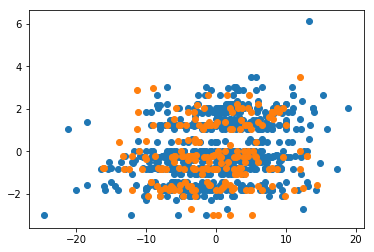

In [444]:
y=y_residual[list(y_trn.gender==1)]
y_pred = model_pred(m,[trn.iloc[list(y_trn.gender==1),:]])[0]
print(metrics.r2_score(y,y_pred),metrics.mean_squared_error(y,y_pred))
plt.scatter(y,y_pred,marker='o')

y=y_rtest[list(y_val.gender==1)]
y_pred = model_pred(m,[val.iloc[list(y_val.gender==1),:]])[0]
print(metrics.r2_score(y,y_pred),metrics.mean_squared_error(y,y_pred))
plt.scatter(y,y_pred,marker='o')

0.06033264203348254 25.71971959141726
-0.011266568386051334 31.09103766575524


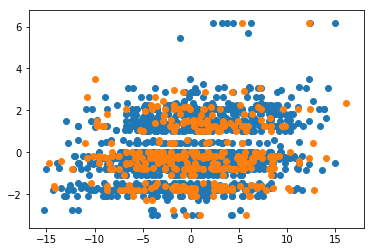

In [445]:
y=y_residual[list(y_trn.gender==2)]
y_pred = model_pred(m,[trn.iloc[list(y_trn.gender==2),:]])[0]
print(metrics.r2_score(y,y_pred),metrics.mean_squared_error(y,y_pred))
plt.scatter(y,y_pred,marker='o')

y=y_rtest[list(y_val.gender==2)]
y_pred = model_pred(m,[val.iloc[list(y_val.gender==2),:]])[0]
print(metrics.r2_score(y,y_pred),metrics.mean_squared_error(y,y_pred))
plt.scatter(y,y_pred,marker='o')

In [421]:
from models import save_model

In [422]:
save_model(m,'best_rf',out_dir='TTS_Model/')

In [423]:
rf_feat_importance(m,trn)

,cols,imp
6,kgp5403113,0.246135
4,rs16932725,0.219535
3,rs7624084,0.151963
8,rs724016,0.149973
1,rs1712374,0.072751
7,rs6535239,0.047712
0,rs710841,0.045648
5,rs1901568,0.034193
2,rs710839,0.032090


In [426]:
m1=m

In [30]:
x = y_trn.gender.values
y = y_trn.height.values
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
y_residual = y-(intercept + slope*x)
y_rtest = y_val.height-(intercept+slope*y_val.gender)

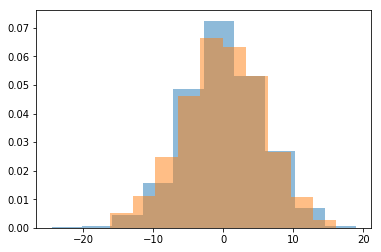

In [31]:
plt.hist(y_residual,density=True,alpha=0.5)
plt.hist(y_rtest,density=True,alpha=0.5)
plt.show()

In [45]:
from sklearn.model_selection import KFold

In [49]:
X=trn.values
y = y_residual

In [51]:
X.shape[1]

684066

In [119]:
result={}
for j in range(10):
    kf=KFold(n_splits=5, random_state=j, shuffle=True)
    result[j]=[]
    for train_index, test_index in kf.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        trn_result={}
        val_result={}
        for i,t,v in zip(list(range(X.shape[1])),X_train.T,X_test.T):
            trn_result[i]=list(stats.linregress(t,y_train))
            val_result[i]=list(stats.linregress(v,y_test))
        result[j].append(pd_gwas(trn_result,tz_sub,val_result))

TRAIN: [   0    2    3    4    5    7    8   10   11   12   13   16   19   20   21   22   24   25   26   28 ... 2170
 2171 2172 2174 2176 2177 2178 2179 2180 2181 2182 2183 2187 2189 2190 2191 2193 2194 2195 2196] TEST: [   1    6    9   14   15   17   18   23   27   30   31   37   39   41   47   48   53   57   70   76 ... 2117
 2119 2124 2125 2133 2136 2139 2149 2158 2160 2162 2164 2166 2173 2175 2184 2185 2186 2188 2192]
TRAIN: [   0    1    3    6    7    8    9   12   13   14   15   16   17   18   20   21   23   24   25   26 ... 2174
 2175 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2191 2192 2193 2194 2195] TEST: [   2    4    5   10   11   19   22   34   40   45   52   54   55   58   61   64   66   82   87   89 ... 2088
 2089 2090 2091 2102 2114 2115 2123 2129 2131 2134 2143 2144 2146 2167 2169 2170 2176 2190 2196]
TRAIN: [   0    1    2    3    4    5    6    7    9   10   11   12   14   15   17   18   19   20   21   22 ... 2169
 2170 2171 2172 2173 2175 217

TRAIN: [   0    1    2    3    4    5    6    7    9   10   12   13   14   15   16   17   18   19   21   22 ... 2168
 2169 2171 2172 2174 2175 2176 2179 2180 2182 2183 2184 2185 2186 2187 2188 2193 2194 2195 2196] TEST: [   8   11   20   26   29   31   41   47   49   57   58   67   68   70   75   76   87   88   98  104 ... 2127
 2131 2135 2137 2138 2139 2146 2149 2153 2164 2166 2170 2173 2177 2178 2181 2189 2190 2191 2192]
TRAIN: [   0    1    3    4    6    7    8    9   11   12   14   16   17   18   19   20   21   22   23   24 ... 2170
 2171 2172 2173 2174 2177 2178 2180 2181 2182 2185 2186 2187 2188 2189 2190 2191 2192 2193 2195] TEST: [   2    5   10   13   15   34   38   40   53   55   63   64   65   66   71   72   74   83   89   90 ... 2089
 2098 2103 2105 2107 2114 2120 2129 2136 2141 2145 2156 2160 2175 2176 2179 2183 2184 2194 2196]
TRAIN: [   0    1    2    3    5    6    7    8    9   10   11   12   13   14   15   16   18   20   22   23 ... 2175
 2176 2177 2178 2179 2180 218

TRAIN: [   0    1    2    3    4    5    6    7    8    9   10   11   13   14   16   17   18   19   20   21 ... 2172
 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2190 2191 2192 2193 2194 2196] TEST: [  12   15   32   49   54   58   61   64   70   73   77   78   83   84   89   92   94  101  102  108 ... 2111
 2119 2121 2127 2133 2136 2137 2138 2143 2147 2148 2152 2160 2166 2171 2173 2174 2175 2189 2195]
TRAIN: [   1    2    3    4    5    6    7    8    9   10   11   12   13   15   17   19   20   21   23   24 ... 2173
 2174 2175 2177 2178 2180 2181 2183 2184 2185 2186 2187 2188 2189 2190 2191 2192 2194 2195 2196] TEST: [   0   14   16   18   22   26   30   37   40   41   43   48   51   60   63   65   74   75   80   81 ... 2075
 2078 2083 2084 2112 2118 2123 2128 2129 2140 2141 2145 2157 2168 2169 2172 2176 2179 2182 2193]
TRAIN: [   0    1    2    3    5    6    7   11   12   13   14   15   16   17   18   19   21   22   23   24 ... 2174
 2175 2176 2177 2178 2179 218

In [120]:
with open(TMP_PATH/'heigt_gwas_5cv10rep.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [68]:
with open(TMP_PATH/'heigt_gwas_5cv10rep.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(all(result == b))

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [121]:
len(result[0][0])

684066

In [122]:
tmpr = result[0][1]

In [123]:
tmpr.head()

,slope,intercept,rvalue,pvalue,stderr,valp,prank
rs4612347,-1.078284,1.506921,-0.126586,1.016678e-07,0.201697,0.484618,344056
rs7624084,-0.998996,1.291344,-0.124712,1.569105e-07,0.189720,0.771497,138650
rs1057308,-1.050580,1.510806,-0.120735,3.859234e-07,0.206191,0.303639,344060
rs724016,-0.967797,1.277458,-0.118402,6.457451e-07,0.193740,0.709557,138655
rs978580,-1.031455,1.487092,-0.118080,6.927736e-07,0.207054,0.255485,344061


In [124]:
def trnvalpcut(r,tp=0.0001,vp=0.05):
    return r[(r.valp<vp) & (r.pvalue<tp)]

In [125]:
[len(re) for re in result.values()]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [141]:
tmpr = [trnvalpcut(r,tp=0.001) for re in result.values() for r in re]

In [142]:
len(tmpr)

50

In [99]:
tmpr = [[trnvalpcut(r,tp=0.001) for r in re] for re in result]

In [143]:
tmpr_rs = pd.Series([rs for t in tmpr for rs in list(t.index)])

In [144]:
tmpr_rs_c1=tmpr_rs.value_counts()

In [135]:
tmpr_rs_c=tmpr_rs.value_counts()

In [140]:
tmpr_rs_c.to_csv('TTS_Model/gwas_snp_5cv10rep_p0001.csv',index=None)

In [146]:
tmpr_rs_c1.to_csv('TTS_Model/gwas_snp_5cv10rep_p001.csv',index=None)

In [33]:
trn_result={}
val_result={}
for i,t,v in zip(list(range(trn.shape[1])),trn.T.values,val.T.values):
    trn_result[i]=list(stats.linregress(t,y_residual))
    val_result[i]=list(stats.linregress(v,y_rtest))


In [39]:
def pd_gwas(gwas,plink,val_gwas):
    snps_gwas=pd.DataFrame(gwas)
    snp_pv_idx=list(np.argsort(snps_gwas.iloc[3,:]))
    snps_gwas=snps_gwas.T
    snps_gwas.columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']
    snps_val_gwas=pd.DataFrame(val_gwas).T
    snps_val_gwas.columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']
    
    snps_gwas['valp']=snps_val_gwas.pvalue
    snps_gwas=snps_gwas.iloc[snp_pv_idx,:]
    snps_gwas['prank'] = snp_pv_idx
    new_plink=plink_slice(plink,snp_pv_idx)
    snps_gwas.index = list(new_plink[0].snp)
    return snps_gwas
    

In [40]:
tmp = pd_gwas(trn_result,tz_sub,val_result)

In [43]:
tmp.loc[tmp.valp<0.05,:].head(1000)

,slope,intercept,rvalue,pvalue,stderr,valp,prank
rs710839,-1.026587,1.695246,-0.101594,0.000002,0.214565,0.048868,169458
kgp5403113,0.794079,-0.986002,0.099140,0.000003,0.170118,0.037357,599101
rs13837,0.836877,-1.210557,0.096648,0.000006,0.183955,0.035125,176333
kgp11672887,-1.011053,1.685242,-0.094454,0.000009,0.227453,0.049819,169475
kgp1942428,0.823122,-1.229625,0.091671,0.000017,0.190847,0.043223,59802
rs7287557,0.928266,-1.597952,0.082958,0.000099,0.238011,0.024128,659728
rs924164,0.660176,-0.802908,0.081082,0.000142,0.173216,0.023933,340825
rs13440292,0.831306,-1.375420,0.080015,0.000174,0.221044,0.035278,372832
kgp4088554,0.638954,-0.782334,0.079462,0.000193,0.171087,0.018391,340814
kgp1631988,-0.746402,1.164958,-0.079103,0.000206,0.200771,0.030202,560329


In [62]:
save_gwas(trn_result,tz_sub,path='TTS_Model/gwas_trn_result.csv')

In [63]:
save_gwas(val_result,tz_sub,path='TTS_Model/gwas_val_result.csv')

In [50]:
from snp2h import boo2idx

In [51]:
f_trn_idx = boo2idx(y_trn.gender==2)

In [64]:
((f_trn,m_trn), (f_ytr,m_ytr)) = split_by_idx(f_trn_idx, trn, y_residual)

In [65]:
f_trn.shape,m_trn.shape

((1416, 684066), (781, 684066))

In [67]:
f_trn_result={}
m_trn_result={}
for i,t,v in zip(list(range(f_trn.shape[1])),f_trn.T,m_trn.T):
    f_trn_result[i]=list(stats.linregress(t,f_ytr))
    m_trn_result[i]=list(stats.linregress(v,m_ytr))

In [68]:
save_gwas(f_trn_result,tz_sub,path='TTS_Model/gwas_trn_result_female.csv')
save_gwas(m_trn_result,tz_sub,path='TTS_Model/gwas_trn_result_male.csv')